In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Queretaro hexagons

In [3]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

OperationalError: (psycopg2.OperationalError) could not translate host name "None" to address: Temporary failure in name resolution

(Background on this error at: https://sqlalche.me/e/20/e3q8)

### Nodes data

In [3]:
year = 2020

#Folder names from database
schema = 'prox_analysis'
nodes_folder = 'nodes_proximity_2020'

c = 'Guadalajara'

query = f"SELECT * FROM {schema}.{nodes_folder} WHERE \"metropolis\" LIKE \'{c}\'"
nodes = proylib.gdf_from_query(query, geometry_col='geometry')

print(nodes.shape)
nodes.head(2)

(8405326, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,291178441,-103.403142,20.674896,POINT (-103.40314 20.67490),0.0,sip_teatro,Guadalajara
1,290903434,-103.568595,20.715512,POINT (-103.56860 20.71551),0.0,sip_teatro,Guadalajara


## Data treatment

Create nodes only with geometry

In [4]:
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','metropolis']].copy()

print(nodes_geom.shape)
nodes_geom.head(2)

(195754, 3)


,osmid,geometry,metropolis
75873,1948147671,POINT (-102.91089 20.61531),Guadalajara
78167,1999519726,POINT (-103.65316 20.71338),Guadalajara


Transform nodes to columns

In [5]:
nodes_analysis = nodes_geom.copy()

for amenidad in list(nodes.amenity.unique()):
    nodes_tmp = nodes.loc[nodes.amenity == amenidad,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':amenidad})
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')

del nodes    
del nodes_geom
del nodes_tmp

print(nodes_analysis.shape)
nodes_analysis.head(2)

(195466, 46)


,osmid,geometry,metropolis,sip_teatro,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,sip_mercado,clues_primer_nivel,clues_segundo_nivel,...,denue_cines,denue_centro_cultural,denue_parque_natural,denue_papelerias,denue_libros,denue_revistas_periodicos,denue_ferreteria_tlapaleria,denue_art_limpieza,denue_pintura,denue_peluqueria
0,325720651,POINT (-103.12068 20.57727),Guadalajara,0.0,34.127093,53.900637,5.413357,124.004579,7.526527,121.725663,...,180.149389,59.944595,422.913259,3.12239,367.528439,265.813416,5.555095,95.436223,10.885584,4.041667
1,325720652,POINT (-103.12119 20.57735),Guadalajara,0.0,33.310193,53.083737,4.596457,124.006688,6.709627,121.727773,...,179.332489,59.127695,422.096359,2.30549,366.711539,264.996516,4.976232,94.619323,10.068684,3.224767


<AxesSubplot: >

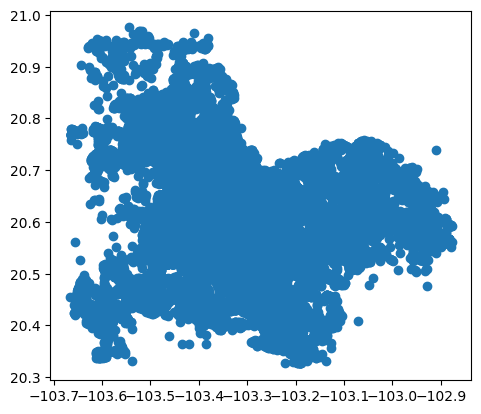

In [6]:
nodes_analysis.plot()

In [7]:
nodes_analysis.columns.to_list()

['osmid',
 'geometry',
 'metropolis',
 'sip_teatro',
 'sip_cancha',
 'sip_unidad_deportiva',
 'sip_espacio_publico',
 'sip_mercado',
 'clues_primer_nivel',
 'clues_segundo_nivel',
 'clues_tercer_nivel',
 'sigade_preescolar',
 'sigade_primaria',
 'sigade_secundaria',
 'sip_centro_admin',
 'denue_preescolar',
 'denue_primaria',
 'denue_secundaria',
 'denue_escuela_mixta',
 'denue_casa_adultos_mayores',
 'denue_guarderias',
 'denue_dif',
 'denue_biblioteca',
 'denue_supermercado',
 'denue_abarrotes',
 'denue_carnicerias',
 'denue_farmacias',
 'denue_ropa',
 'denue_calzado',
 'denue_muebles',
 'denue_lavanderia',
 'denue_cafe',
 'denue_restaurante_insitu',
 'denue_restaurante_llevar',
 'denue_bares',
 'denue_museos',
 'denue_cines',
 'denue_centro_cultural',
 'denue_parque_natural',
 'denue_papelerias',
 'denue_libros',
 'denue_revistas_periodicos',
 'denue_ferreteria_tlapaleria',
 'denue_art_limpieza',
 'denue_pintura',
 'denue_peluqueria']

## Data analysis

Amenities used for analysis

In [8]:
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                      'Guarderías':['denue_guarderias'],
                                      'Asistencia social':['denue_dif']},
              'Comercio':{'Alimentos':['denue_supermercado','denue_abarrotes',
                                    'denue_carnicerias','sip_mercado'],
                         'Personal':['denue_peluqueria'],
                          'Farmacias':['denue_farmacias'],
                         'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                         'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                           'denue_lavanderia','denue_revistas_periodicos',
                                           'denue_pintura']},
              'Entretenimiento':{'Social':
                                 ['denue_restaurante_insitu','denue_restaurante_llevar',
                                          'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
              'sip_espacio_publico','denue_parque_natural'],
              'Cultural':['denue_cines','denue_museos','denue_biblioteca',
                         'denue_centro_cultural']} 
             }

wegiht_idx = {'Escuelas':{'Preescolar':1,
                         'Primaria':1,
                         'Secundaria':1},
             'Servicios comunitarios':{'Salud':1,
                                      'Guarderías':1,
                                      'Asistencia social':1},
              'Comercio':{'Alimentos':1,
                         'Personal':1,
                          'Farmacias':1,
                         'Hogar':1,
                         'Complementarios':1},
              'Entretenimiento':{'Social':1,
                                'Actividad física':1,
                                'Cultural':1}
             }

In [9]:
tiempos_15_min = {'denue_preescolar':[5,'peatonal'],
                 'denue_primaria':[5,'peatonal'],
                 'denue_secundaria':[15,'peatonal'],
                  'denue_escuela_mixta':[15,'peatonal'],
                 'clues_primer_nivel':[5,'peatonal'],
                 'sip_centro_admin':[10,'bicicleta'],
                 'denue_guarderias':[5,'peatonal'],
                 'denue_casa_adultos_mayores':[5,'peatonal'],
                 'denue_dif':[10,'bicicleta'],
                 'denue_supermercado':[5,'peatonal'],
                 'denue_abarrotes':[5,'peatonal'],
                 'denue_carnicerias':[5,'peatonal'],
                 'sip_mercado':[5,'peatonal'],
                 'denue_peluqueria':[10,'bicicleta'],
                  'denue_farmacias':[5,'peatonal'],
                  'denue_ferreteria_tlapaleria':[15,'peatonal'],
                  'denue_art_limpieza':[15,'peatonal'],
                  'denue_ropa':[15,'peatonal'],
                  'denue_calzado':[15,'peatonal'],
                  'denue_muebles':[15,'peatonal'],
                  'denue_lavanderia':[15,'peatonal'],
                  'denue_revistas_periodicos':[15,'peatonal'],
                  'denue_pintura':[15,'peatonal'],
                  'denue_restaurante_insitu':[15,'peatonal'],
                  'denue_restaurante_llevar':[15,'peatonal'],
                  'denue_bares':[15,'peatonal'],
                  'denue_cafe':[15,'peatonal'],
                  'sip_cancha':[5,'peatonal'],
                  'sip_unidad_deportiva':[5,'peatonal'],
                  'sip_espacio_publico':[5,'peatonal'],
                  'denue_parque_natural':[10,'bicicleta'],
                  'denue_cines':[10,'bicicleta'],
                  'denue_museos':[10,'bicicleta'],
                  'denue_biblioteca':[10,'bicicleta'],
                  'denue_centro_cultural':[10,'bicicleta'],
                 }

Determine amenity proximity

In [10]:
# determines whether a certain amenity is within the limit time 
for amenidad in list(tiempos_15_min.keys()):
    # creates column to save whether a amenity is within the limit time
    idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
    nodes_analysis[idx_column_name] = 0
    
    tiempo_limite = 15
        
    idx_amenidad = nodes_analysis[amenidad] <= tiempo_limite
    nodes_analysis.loc[idx_amenidad, idx_column_name] = 1

Calculate binary index

In [11]:
cat_list = []

for cat in idx_15_min.keys():
    
    cat_list.append(cat)
    
    subcat_list = []
    
    for subcat in idx_15_min[cat]:
        
        subcat_list.append(subcat)
                
        subcat_amenities_list = []
        time_subcat_amenities_list = []
        
        for amenidad in idx_15_min[cat][subcat]:
            
            idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
            subcat_amenities_list.append(idx_column_name)
        
        if len(subcat_amenities_list) > wegiht_idx[cat][subcat]:
            idx = nodes_analysis[subcat_amenities_list].sum(axis=1) >= 1
            nodes_analysis.loc[idx, subcat] = 1
        else:
            nodes_analysis[subcat] = (nodes_analysis[subcat_amenities_list].sum(axis=1) / wegiht_idx[cat][subcat])
           
    nodes_analysis[cat] = nodes_analysis[subcat_list].sum(axis=1)
    
nodes_analysis['15_min_analysis'] = nodes_analysis[cat_list].sum(axis=1)

In [12]:
subcat_list

['Social', 'Actividad física', 'Cultural']

In [13]:
subcat_amenities_list

['idx_cines', 'idx_museos', 'idx_biblioteca', 'idx_centro_cultural']

Group by hexagon

In [14]:
col_name = '15_min_analysis'
res = 9
hex_binary = proylib.group_by_hex_mean(nodes_analysis, hex_gdf, res, col_name)

In [15]:
hex_binary

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,sip_teatro,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,...,Personal,Farmacias,Hogar,Complementarios,Comercio,Social,Actividad física,Cultural,Entretenimiento,15_min_analysis
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,70.818606,49.457691,5.999799,...,1.000000,1.000000,1.0,1.0,5.000000,1.0,1.0,1.0,3.00,13.982759
1,89498c946d7ffff,"POLYGON ((-103.28639 20.66389, -103.28517 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,24.582441,8.995783,4.408047,...,1.000000,1.000000,1.0,1.0,5.000000,1.0,1.0,1.0,3.00,14.000000
2,89498c94ed7ffff,"POLYGON ((-103.32570 20.71522, -103.32448 20.7...",14039,Guadalajara,Guadalajara,urban,0.0,5.930357,34.807184,1.907214,...,1.000000,1.000000,1.0,1.0,5.000000,1.0,1.0,1.0,3.00,14.000000
3,89498c9710bffff,"POLYGON ((-103.28775 20.65026, -103.28653 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,20.439739,16.750849,5.839887,...,1.000000,1.000000,1.0,1.0,5.000000,1.0,1.0,0.0,2.00,12.268293
4,89498c94567ffff,"POLYGON ((-103.33174 20.68653, -103.33052 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,19.071704,25.298023,6.044568,...,1.000000,1.000000,1.0,1.0,5.000000,1.0,1.0,1.0,3.00,12.970588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.33230 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,49.800032,43.132779,4.247840,...,0.833333,1.000000,1.0,1.0,4.750000,1.0,1.0,0.0,2.00,9.416667
1210,89498c95cb3ffff,"POLYGON ((-103.29386 20.71601, -103.29264 20.7...",14039,Guadalajara,Guadalajara,urban,0.0,9.172581,34.340161,6.004637,...,1.000000,0.916667,1.0,1.0,4.916667,1.0,1.0,1.0,3.00,11.583333
1211,89498c95dcbffff,"POLYGON ((-103.29582 20.72820, -103.29459 20.7...",14039,Guadalajara,Guadalajara,urban,0.0,34.639120,64.566828,22.839729,...,0.250000,0.000000,1.0,0.0,0.750000,1.0,0.0,0.0,0.25,1.000000
1212,89498c96edbffff,"POLYGON ((-103.34739 20.65692, -103.34617 20.6...",14039,Guadalajara,Guadalajara,urban,0.0,59.862392,52.234331,1.687513,...,1.000000,1.000000,1.0,1.0,5.000000,1.0,1.0,1.0,3.00,10.470588


## Visualization

In [16]:
columns_analysis = ['Preescolar','Primaria','Secundaria',
             'Salud','Guarderías','Asistencia social'
                    'Alimentos','Personal','Hogar',
            'Complementarios', 'Farmacias',
              'Social','Actividad física','Cultural',
                    '15_min_analysis'
             ]

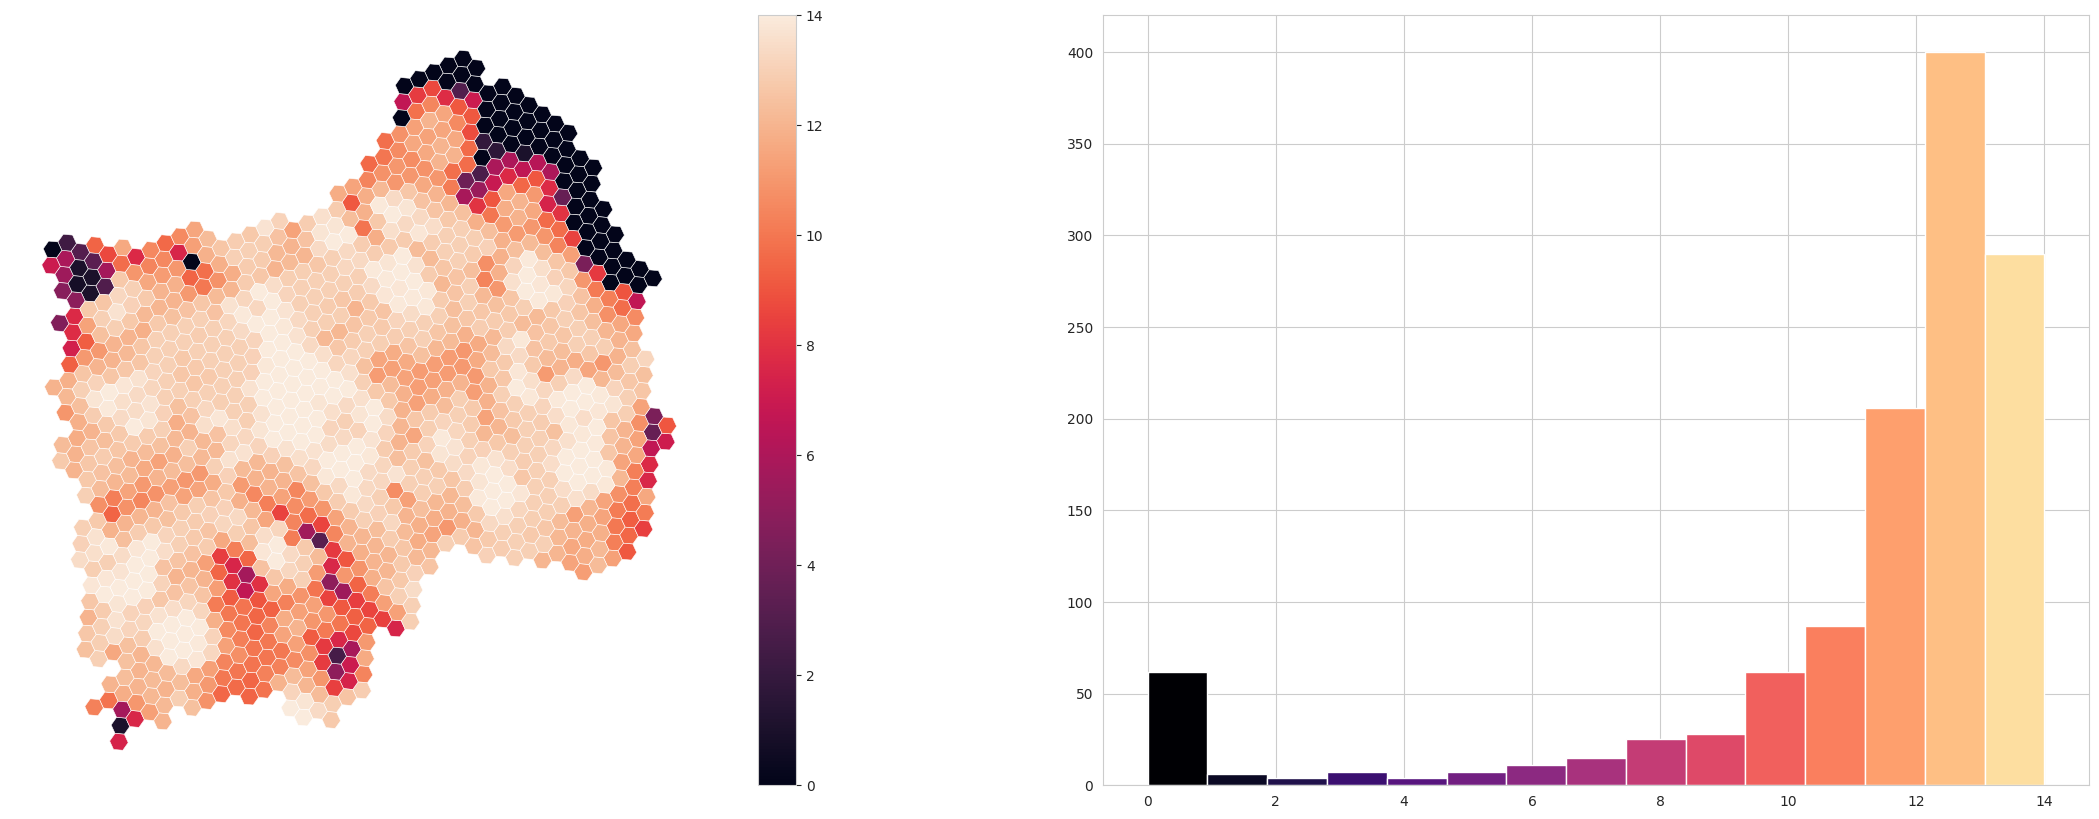

In [17]:
import seaborn as sns 

column_analysis = '15_min_analysis'

sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(28,10))
hex_binary.plot(column=column_analysis, linewidth=0.4,
                       legend=True, ax=ax[0]) 
ax[0].set_axis_off()

hex_binary.sort_values(column_analysis,inplace=True)
hex_binary.reset_index(drop=True, inplace=True)
n, bins, patches = ax[1].hist(hex_binary[column_analysis],
                             15, color='green')

cm = plt.cm.magma
 
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/len(n))) # notice the i/25


In [18]:
hex_binary.to_file('../data/processed/hex_proximity.geojson')